# PSO – Particle Swarm Optimization (részletes, magyarázatos verzió)

Ebben a notebookban lépésről lépésre van felépítve a **PSO (Particle Swarm Optimization)** algoritmus.
Minden feladat előtt találsz egy rövid **elméleti magyarázatot** és utána jöhetnek a kódok, ahol a `TODO` részeket neked kell kitöltened.

A PSO egy **populáció alapú, metaheurisztikus optimalizáló algoritmus**, amely folytonos keresési térben keres minimumot vagy maximumot.

---

## 1. feladat – Tesztfüggvények definiálása 2D-ben

Először definiálunk néhány klasszikus **benchmark függvényt**, amelyeken kipróbáljuk a PSO-t.

### 1.1 Sphere függvény

A legegyszerűbb tesztfüggvény a *Sphere*:

\[
f(x, y) = x^2 + y^2
\]

Tulajdonságok:

- konvex,
- egyetlen globális minimuma van: \( (x^*, y^*) = (0, 0) \),
- a minimum értéke: \( f(0,0) = 0 \).

### 1.2 Rastrigin függvény

A *Rastrigin* egy **nehéz** tesztfüggvény, sok lokális minimummal:

\[
f(x, y) = 20
+ x^2 - 10 \cos(2\pi x)
+ y^2 - 10 \cos(2\pi y)
\]

Tulajdonságok:

- nagyon sok lokális minimum → jó vizsga a PSO-nak,
- globális minimum: \( (0,0) \),
- globális minimum értéke: \( f(0,0) = 0 \).

### Feladat

Implementáld a két függvényt úgy, hogy a bemenet egy **2 elemű lista** legyen: `[x, y]`.

In [6]:
import math

def sphere(position):
    """Egyszerű konvex függvény: f(x,y) = x^2 + y^2."""
    x, y = position
    return x**2 + y**2

def rastrigin(position):
    """Sok lokális minimummal rendelkező tesztfüggvény."""
    x, y = position
    return 20 + (x**2 - 10 * math.cos(2 * math.pi * x)) + (y**2 - 10 * math.cos(2 * math.pi * y))

print("Sphere(0,0) =", sphere([0,0]))
print("Rastrigin(0,0) =", rastrigin([0,0]))

Sphere(0,0) = 0
Rastrigin(0,0) = 0.0


---

## 2. feladat – A raj (swarm) inicializálása

A PSO-ban nem egyetlen megoldást tartunk nyilván, hanem **sok részecskét** (*particle*).  
Minden részecskére eltároljuk:

- aktuális pozíció: \( x_i^t \in \mathbb{R}^d \),
- aktuális sebesség: \( v_i^t \in \mathbb{R}^d \),
- saját legjobb pozíció: \( p_i \) (ahol eddig a legjobb értéket kapta).

A kezdeti pozíciókat tipikusan véletlenül választjuk:

\[
x_{i,j}^0 \sim U(\text{lower},\, \text{upper})
\]

A sebességek kezdő értékét is választhatjuk véletlenül, pl.:

\[
v_{i,j}^0 \sim U(-|upper-lower|,\, |upper-lower|)
\]

### Feladat

1. Írj függvényt, amely egy `dim` hosszú **véletlen vektort** generál a megadott intervallumban.
2. Írj `init_swarm()` függvényt, amely:
   - létrehozza a pozíciókat és sebességeket,
   - kiszámítja a kezdeti **pbest pozíciókat és értékeket** egy megadott célfüggvényre.

In [12]:
import random

def random_vector(dim, lower, upper):
    """Dimenzió: dim, minden komponens ~ U(lower, upper)."""
    return [random.uniform(lower, upper) for _ in range(dim)]

def init_swarm(num_particles, dim, lower, upper, objective_fn):
    """
    Visszatérés:
      positions        – lista (num_particles darab dim-dimenziós pozíció)
      velocities       – lista (num_particles darab dim-dimenziós sebesség)
      pbest_positions  – kezdetben = positions
      pbest_values     – objective_fn(positions[i]) értékek
    """

    positions = []
    velocities = []
    pbest_positions = []
    pbest_values = []

    vel_lower = -(upper - lower)
    vel_upper = (upper - lower)

    for _ in range(num_particles):
        pos = random_vector(dim, lower, upper)
        positions.append(pos)

        vel = random_vector(dim, vel_lower, vel_upper)
        velocities.append(vel)

        pbest_positions.append(list(pos))
        pbest_values.append(objective_fn(pos))

    return positions, velocities, pbest_positions, pbest_values


# Példa (ha majd készen vagy):
positions, velocities, pbest_pos, pbest_val = init_swarm(10, 2, -5, 5, sphere)
print(len(positions), len(velocities))

10 10


---

## 3. feladat – Swarm kiértékelése, személyes és globális legjobb pozíciók

Minden iterációban ki kell értékelni az összes részecske aktuális pozícióját:

\[
f_i^t = f(x_i^t)
\]

A személyes legjobb (pbest) frissítése:

\[
\text{ha } f(x_i^t) < f(p_i), \quad \text{akkor } p_i := x_i^t
\]

A globális legjobb (gbest) frissítése:

\[
g := \arg\min_i f(p_i)
\]

### Feladat

Implementáld az `evaluate_swarm()` függvényt, amely:

- bejárja az aktuális `positions` listát,
- frissíti a `pbest_positions` és `pbest_values` listákat,
- meghatározza és visszaadja a `gbest_position` és `gbest_value` értékeit.

In [17]:
def evaluate_swarm(positions, pbest_positions, pbest_values, objective_fn):
    """
    positions: aktuális pozíciók
    pbest_positions, pbest_values: eddigi legjobb értékek és pozíciók
    objective_fn: minimalizálandó függvény

    Visszatérés:
      pbest_positions, pbest_values, gbest_position, gbest_value
    """
    gbest_value = float('inf')
    gbest_position = None

    for i in range(len(positions)):
        current_position = positions[i]
        current_value = objective_fn(current_position)

        if current_value < pbest_values[i]:
            pbest_values[i] = current_value
            pbest_positions[i] = list(current_position)

        if pbest_values[i] < gbest_value:
            gbest_value = pbest_values[i]
            gbest_position = list(pbest_positions[i])

    return pbest_positions, pbest_values, gbest_position, gbest_value

---

## 4. feladat – Sebesség- és pozíciófrissítés (PSO dinamika)

A PSO kulcslépése a **sebesség- és pozíciófrissítés**.

### 4.1 Sebességfrissítés

Az i-edik részecske sebessége:

\[
v_i^{t+1} = w v_i^t
+ c_1 r_1 (p_i - x_i^t)
+ c_2 r_2 (g - x_i^t)
\]

- \( w \) – tehetetlenségi súly (inertia weight)
- \( c_1 \) – kognitív (saját) komponens súlya
- \( c_2 \) – szociális (raj) komponens súlya
- \( r_1, r_2 \sim U(0,1) \) véletlen skálázó tényezők

Opcionálisan bevezethetünk **sebességkorlátot**:

\[
v_{i,j}^{t+1} := \max(-v_{\max}, \min(v_{\max}, v_{i,j}^{t+1}))
\]

### 4.2 Pozíciófrissítés

Az i-edik részecske pozíciója:

\[
x_i^{t+1} = x_i^t + v_i^{t+1}
\]

Majd a pozíciót visszavágjuk a megadott tartományba:

\[
x_{i,j}^{t+1} := \max(lower, \min(upper, x_{i,j}^{t+1}))
\]

### Feladat

Implementáld a két függvényt:

- `update_velocities()` – az előző képletek alapján,
- `update_positions()` – egyszerű vektorösszeadás + határok közé szorítás.

In [16]:
import random

def update_velocities(positions, velocities, pbest_positions, gbest_position,
                      w=0.7, c1=1.5, c2=1.5, vmax=None):
    """Frissítsd az összes részecske sebességét a PSO-képlettel."""
    new_velocities = []
    for i in range(len(positions)):
        current_position = positions[i]
        current_velocity = velocities[i]
        pbest = pbest_positions[i]

        r1 = random.uniform(0, 1)
        r2 = random.uniform(0, 1)

        new_v = []
        for j in range(len(current_position)):
            cognitive_component = c1 * r1 * (pbest[j] - current_position[j])
            social_component = c2 * r2 * (gbest_position[j] - current_position[j])

            v_j = w * current_velocity[j] + cognitive_component + social_component

            if vmax is not None:
                v_j = max(-vmax, min(vmax, v_j))
            new_v.append(v_j)
        new_velocities.append(new_v)
    return new_velocities

def update_positions(positions, velocities, lower, upper):
    """Frissítsd a pozíciókat a sebességek alapján, és vágd vissza a tartományba."""
    new_positions = []
    for i in range(len(positions)):
        current_position = positions[i]
        current_velocity = velocities[i]

        new_x = []
        for j in range(len(current_position)):
            x_j = current_position[j] + current_velocity[j]

            x_j = max(lower, min(upper, x_j))
            new_x.append(x_j)
        new_positions.append(new_x)
    return new_positions

---

## 5. feladat – Teljes PSO algoritmus összeállítása

Most már rendelkezésre áll minden építőkocka:

1. `init_swarm()`
2. `evaluate_swarm()`
3. `update_velocities()`
4. `update_positions()`

### A teljes algoritmus menete

**Inicializálás:**
- Swarm létrehozása (pozíciók, sebességek, pbest-ek, gbest).

**Minden iterációban:**

1. Kiértékelés: `evaluate_swarm()`  
2. Sebességfrissítés: `update_velocities()`  
3. Pozíciófrissítés: `update_positions()`  
4. Eltároljuk a legjobb értéket egy `history` listában, hogy később vissza tudjuk rajzolni a konvergenciát.

### Feladat

Implementáld a `run_pso()` függvényt, amely:

- paraméterként megkapja a célfüggvényt (pl. `sphere` vagy `rastrigin`),
- visszaadja:
  - a legjobb megtalált pozíciót (`gbest_position`),
  - a legjobb értéket (`gbest_value`),
  - a konvergenciagörbét (`history` – legjobb érték iterációnként).

In [25]:
def run_pso(objective_fn, num_particles=30, dim=2, lower=-5, upper=5,
            w=0.7, c1=1.5, c2=1.5, vmax=None, n_iters=100):
    """
    objective_fn: minimalizálandó függvény (pl. sphere vagy rastrigin)
    Vissza:
      gbest_position, gbest_value, history
    """
    positions, velocities, pbest_positions, pbest_values = init_swarm(num_particles, dim, lower, upper, objective_fn)

    _, _, gbest_position, gbest_value = evaluate_swarm(positions, pbest_positions, pbest_values, objective_fn)

    history = [gbest_value]

    for _ in range(n_iters):
        pbest_positions, pbest_values, current_gbest_position, current_gbest_value = evaluate_swarm(positions, pbest_positions, pbest_values, objective_fn)

        if current_gbest_value < gbest_value:
            gbest_value = current_gbest_value
            gbest_position = list(current_gbest_position)

        velocities = update_velocities(positions, velocities, pbest_positions, gbest_position,
                                       w=w, c1=c1, c2=c2, vmax=vmax)

        positions = update_positions(positions, velocities, lower, upper)

        history.append(gbest_value)

    return gbest_position, gbest_value, history

In [27]:
best_position_sphere, best_value_sphere, history_sphere = run_pso(objective_fn=sphere, num_particles=50, n_iters=200, lower=-10, upper=10)

print("--- Eredmények a Sphere függvényre ---")
print(f"Legjobb talált pozíció: {best_position_sphere}")
print(f"Legjobb érték ezen a pozíción: {best_value_sphere}")

best_position_rastrigin, best_value_rastrigin, history_rastrigin = run_pso(objective_fn=rastrigin, num_particles=50, n_iters=200, lower=-5.12, upper=5.12, vmax=2.0)

print("\n--- Eredmények a Rastrigin függvényre ---")
print(f"Legjobb talált pozíció: {best_position_rastrigin}")
print(f"Legjobb érték ezen a pozíción: {best_value_rastrigin}")

--- Eredmények a Sphere függvényre ---
Legjobb talált pozíció: [2.3425148004868917e-13, 8.632629913650885e-14]
Legjobb érték ezen a pozíción: 6.232598582760743e-26

--- Eredmények a Rastrigin függvényre ---
Legjobb talált pozíció: [2.0905974870670872e-10, 9.370967888453419e-10]
Legjobb érték ezen a pozíción: 0.0


---

## 6. feladat – Konvergenciagörbe rajzolása

A PSO viselkedését jól lehet szemléltetni az ún. **konvergenciagörbével**:

- a vízszintes tengelyen az iterációk száma,
- a függőleges tengelyen a legjobb érték \( f(g^t) \).

Ha az algoritmus működik, akkor a görbe **csökkenő trendet** mutat.

### Feladat

Implementáld a `plot_convergence()` függvényt.

In [31]:
import matplotlib.pyplot as plt

def plot_convergence(history, title="PSO konvergencia"):
    """Rajzold ki a history listát (legjobb érték iterációnként)."""
    plt.figure(figsize=(10, 6))
    plt.plot(history, marker='o', linestyle='-', markersize=4)
    plt.title(title)
    plt.xlabel("Iteráció")
    plt.ylabel("Legjobb érték (f(gbest))")
    plt.grid(True)
    plt.show()

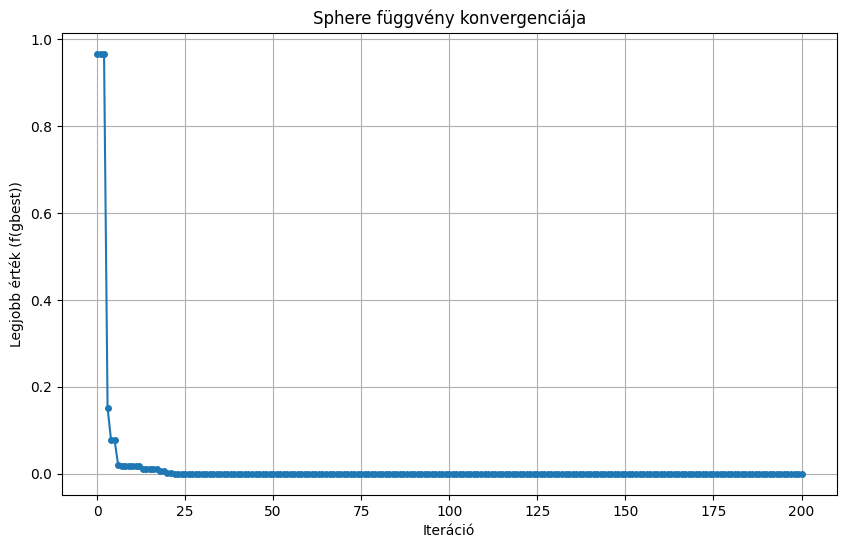

In [32]:
plot_convergence(history_sphere, title="Sphere függvény konvergenciája")

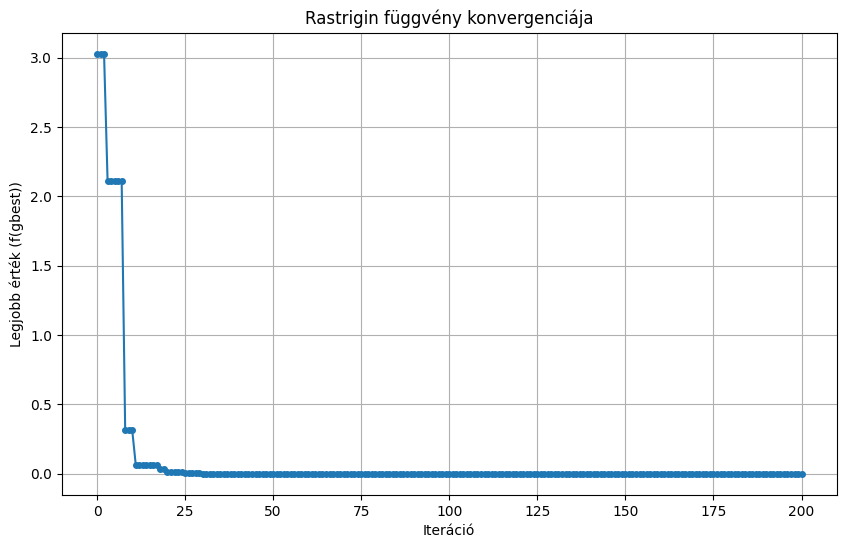

In [33]:
plot_convergence(history_rastrigin, title="Rastrigin függvény konvergenciája")